In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import datetime
from datetime import datetime
import re
import os
import pandas as pd
from scipy.interpolate import *
from scipy.optimize import minimize, newton, NonlinearConstraint

from Local_lib.volsurf import VolatilitySurface, filter_delta, filter_volume
from Local_lib.useful import bs_explicit_call, bs_iv
from Local_lib.volsurf.filters import *

# Load volatility surface and plot SVI fits

In [15]:
date = datetime(2019, 4, 1)
datetime.strftime(date, '%Y%m%d')

'20190401'

c:\Users\Yassir EL-ORFI\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\Users\Yassir EL-ORFI\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_zeros_py.py:479: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Not

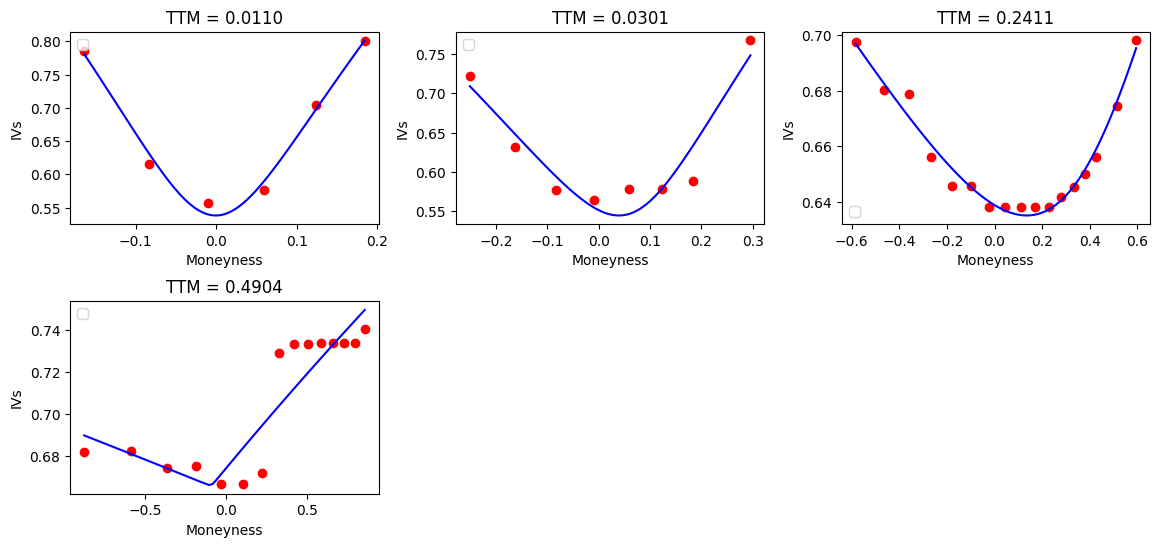

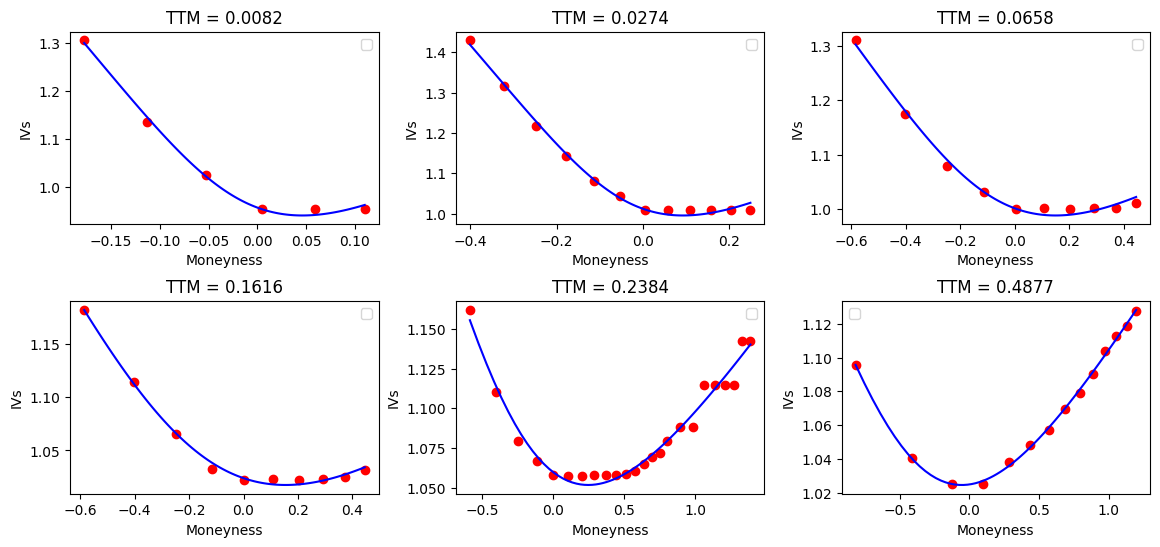

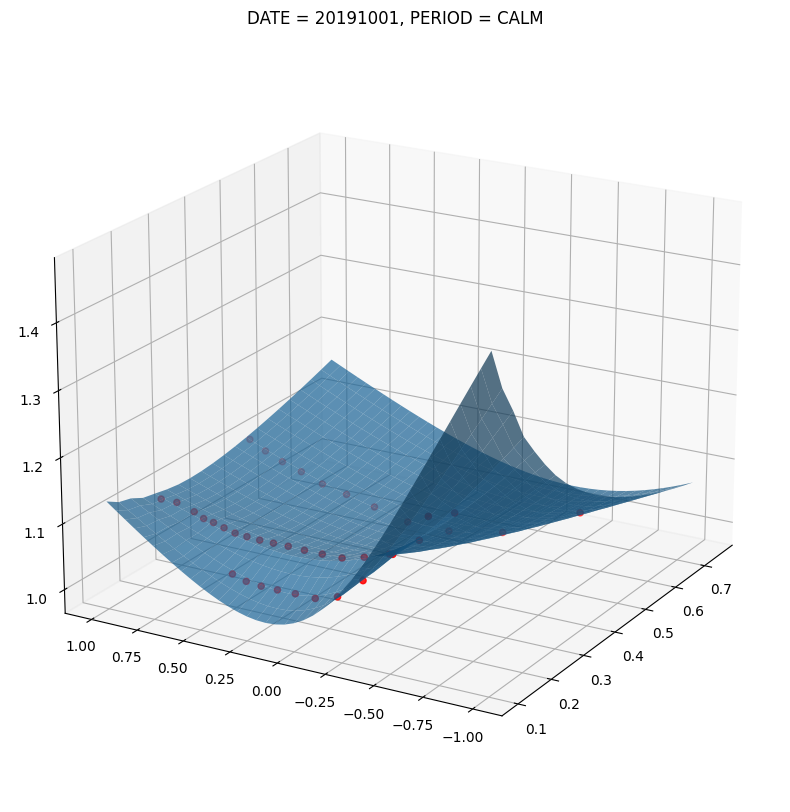

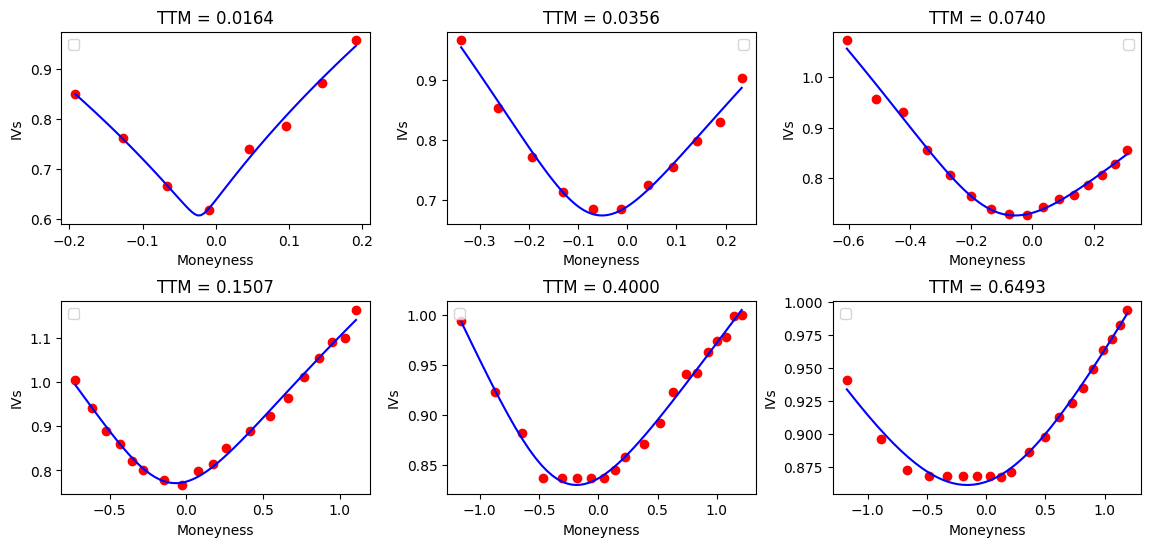

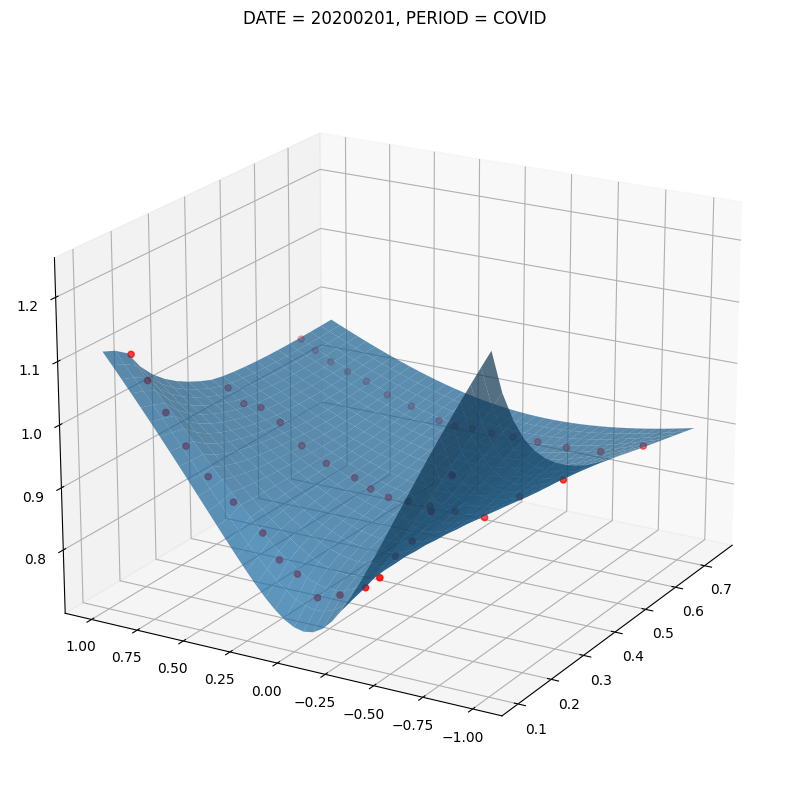

In [17]:
entries = [
    [datetime(2019, 4, 1), "RISING"],
    [datetime(2019, 10, 1), "CALM"],
    [datetime(2020, 2, 1), "COVID"],
]

for date, period_name in entries:

    filters = [filter_delta(0.01)]

    vs = VolatilitySurface.from_date(date, filters=filters)
    vs.calibrate()

    _ = vs.plot()
    #_ = vs.plot_total_variance()
    #_ = vs.plot_points()

    # plot 3d
    
    date_str = datetime.strftime(date, '%Y%m%d')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    BOUND = 1.
    
    # cutoff volsurf at the bottom at this ttm
    bd = 0.1

    x, y = np.meshgrid(np.linspace(bd, 0.75, 21), np.exp(np.linspace(-BOUND, BOUND, 41)))
    z = vs.iv(x, y)

    ax.set_title(f"DATE = {date_str}, PERIOD = {period_name}")
    
    ax.view_init(azim=210, elev=20)
    ax.plot_surface(x, np.log(y), z, linewidth=0.2, antialiased=True, alpha=0.7)

    df = vs.data[np.abs(np.log(vs.data['moneyness'])) <= BOUND]
    ax.scatter(df.loc[df['ttm'] > bd, 'ttm'], np.log(df.loc[df['ttm'] > bd, 'moneyness']), df.loc[df['ttm'] > bd, 'iv'], c='r')

    fig.savefig(f'Results/volsurf/figures/{date_str}.pdf', bbox_inches='tight')

# Calculate IV for all paths

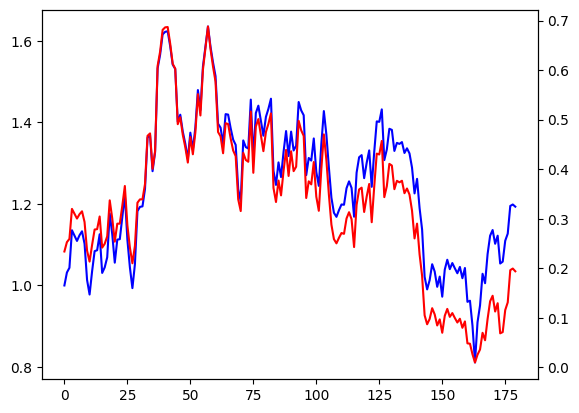

In [18]:
dt = 1/365
sigma = 1.
s0 = 1.
rate = 0.

paths = s0 * np.exp(np.cumsum(np.pad(sigma**2/2 * dt + sigma * np.sqrt(dt) * np.random.standard_normal((10000, 179)), ((0, 0), (1, 0))), axis=1))
ttm = np.linspace(180 * dt, dt, 180)
strike = 1.

iv = vs.iv(ttm, strike / paths)
calls = bs_explicit_call(ttm, strike, paths, rate, vs.iv(ttm, strike / paths))

fig, ax = plt.subplots()

idx = 0
ax.plot(paths[idx, :], c='b')
ax.twinx().plot(calls[idx, :], c='r')

# Examine SVI fits

In [19]:
pd.options.display.float_format = '{:.4f}'.format


In [31]:
fnames = [fname for fname in os.listdir("Results/volsurf/svi") if fname.endswith("csv")]
rows = []
for fname in fnames:
    df = pd.read_csv("Results/volsurf/svi/" + fname)
    items = df[['ttm', 'a', 'b', 'rho', 'm', 'sigma', 'penalty']].to_numpy()
    date = fname[:8]
    rows += [[date, *item] for item in items]

df = pd.DataFrame(rows, columns=['date', 'ttm', 'a', 'b', 'rho', 'm', 'sigma', 'penalty'])

df1 = df[(df['date'] > '20190401') & (df['date'] < '20191001')]
df2 = df[(df['date'] > '20191001') & (df['date']< '20200201')]
df3 = df[(df['date'] > '20200201') & (df['date']< '20200701')]
df3.head().to_clipboard(excel=True,sep="&",float_format="{:.4f}")

In [26]:
fnames = [fname for fname in os.listdir("Results/volsurf/svi") if fname.endswith("csv")]
rows = []

for fname in fnames:
    df = pd.read_csv("Results/volsurf/svi/" + fname)
    items = df[['ttm', 'a', 'b', 'rho', 'm', 'sigma', 'penalty']].to_numpy()
    date = fname[:8]
    rows += [[date, *item] for item in items]
    
df = pd.DataFrame(rows, columns=['date', 'ttm', 'a', 'b', 'rho', 'm', 'sigma', 'penalty'])

In [59]:
df.sort_values('penalty', ascending=False).head()

,date,ttm,a,b,rho,m,sigma,penalty
0,20190401,0.0110,0.1707,0.1000,0.0000,0.0048,1.0000,24.5338
2007,20200326,0.0027,0.0022,0.0435,0.0413,0.0377,0.0316,4.6854
1424,20191226,0.0027,0.0004,0.0355,-0.4578,0.0051,0.0100,2.4364
909,20190923,0.0110,0.0028,0.0598,-0.5000,-0.0092,0.0100,2.1946
1419,20191225,0.0055,0.0007,0.0522,-0.3565,0.0084,0.0100,1.8806


In [62]:
date = datetime.strptime("20200326", "%Y%m%d")
vs = VolatilitySurface(date)
_ = vs.plot()
_ = vs.plot_total_variance()

TypeError: 'datetime.datetime' object is not callable